Found tickers: ['XOM', 'AAPL', 'MSFT', 'GOOG']


/var/folders/gw/yb8707jd1qdbx7xhbkpxsjgr0000gn/T/ipykernel_10113/2242642780.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tickers = pd.read_sql(tickers_query, conn)['ticker'].tolist()
/var/folders/gw/yb8707jd1qdbx7xhbkpxsjgr0000gn/T/ipykernel_10113/2242642780.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=tickers)


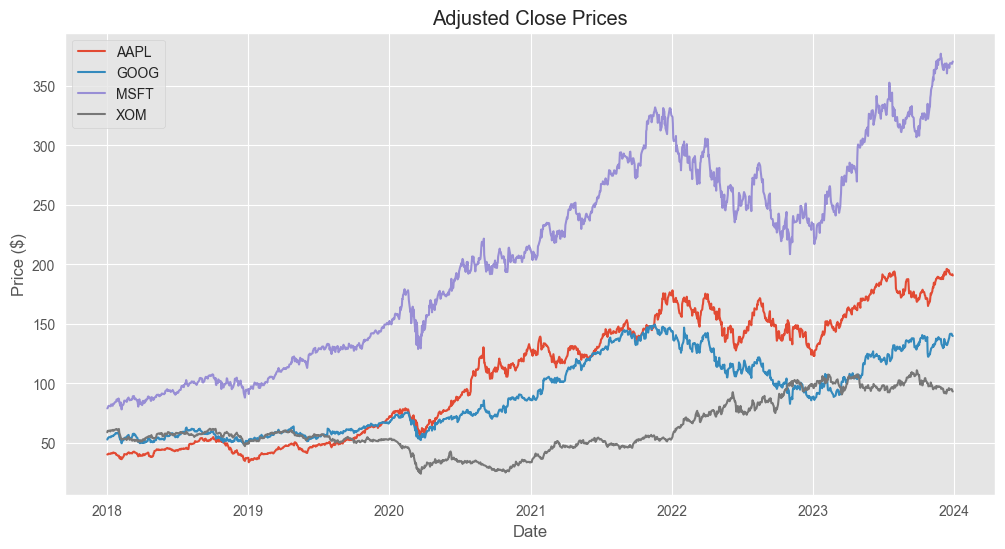

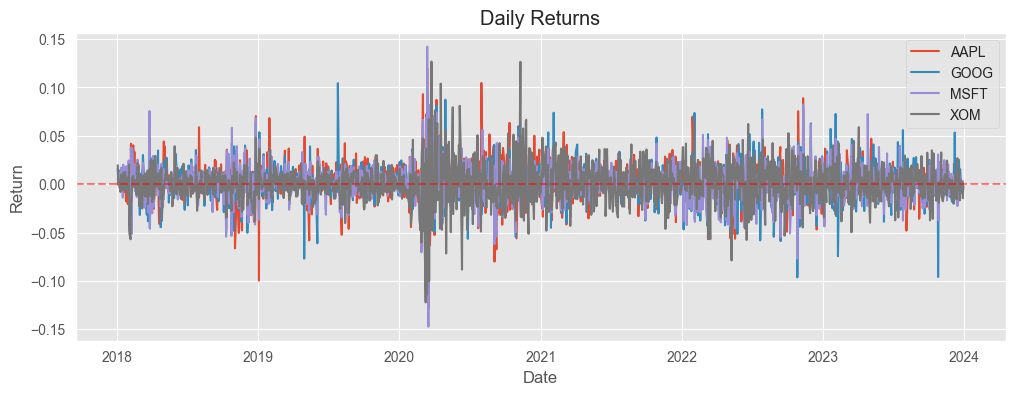

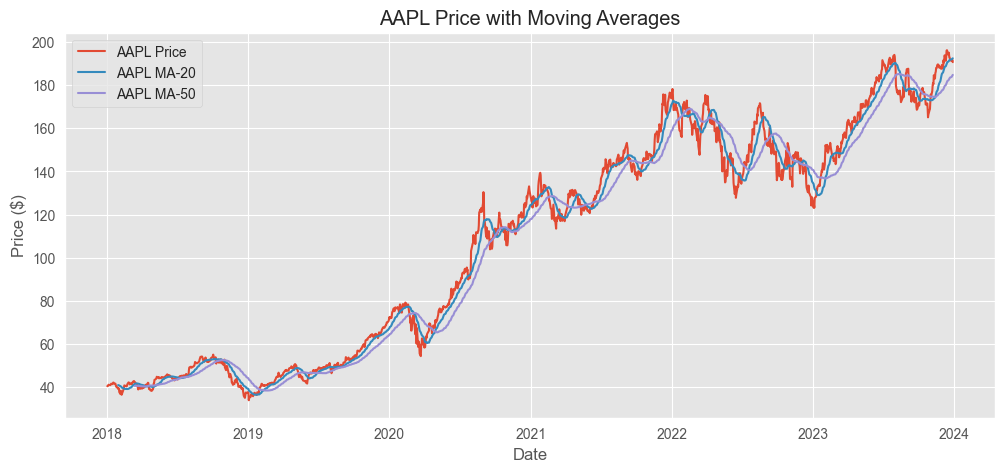

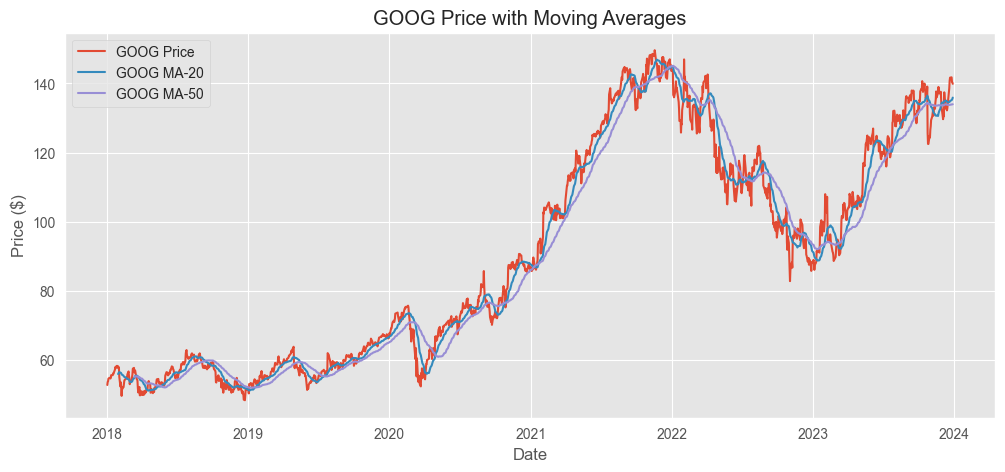

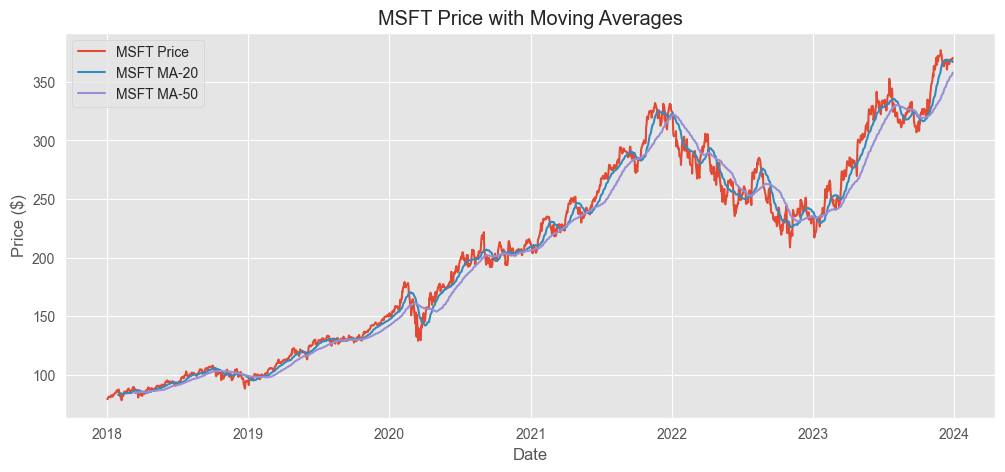

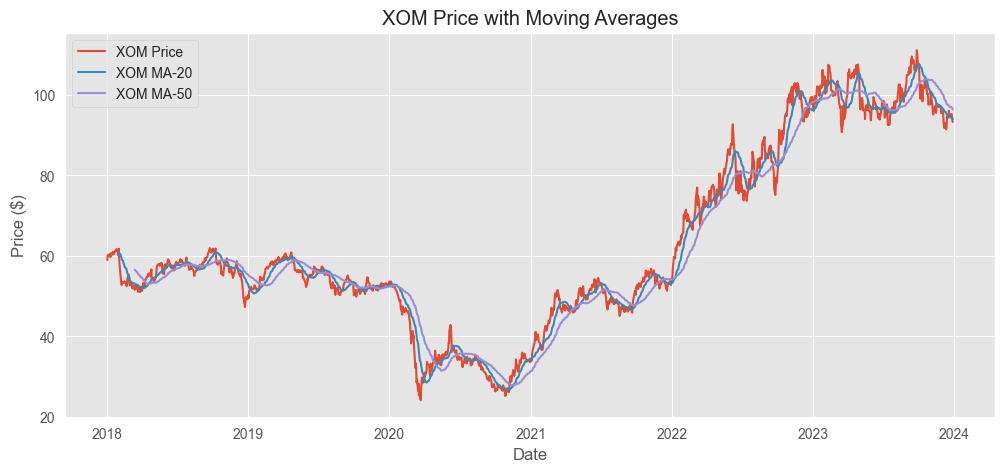

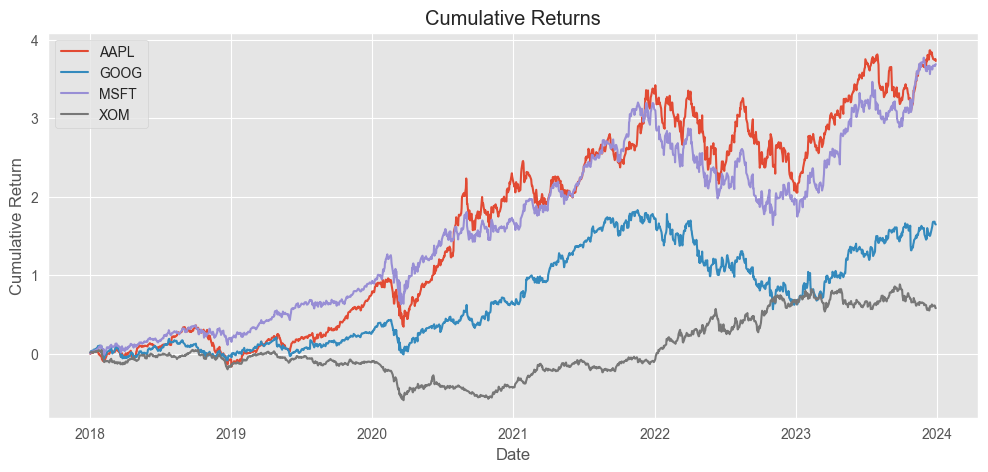

Daily Returns Summary:
ticker         AAPL         GOOG         MSFT          XOM
count   1508.000000  1508.000000  1508.000000  1508.000000
mean       0.001230     0.000839     0.001205     0.000514
std        0.019955     0.019670     0.018976     0.020504
min       -0.128647    -0.111008    -0.147390    -0.122248
25%       -0.008261    -0.008749    -0.008062    -0.010334
50%        0.001176     0.001072     0.001317     0.000283
75%        0.011895     0.011010     0.010964     0.011037
max        0.119808     0.104485     0.142169     0.126868


In [10]:
# analysis_dynamic_full.ipynb

import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# -----------------------------
# 1️⃣ MySQL connection
# -----------------------------
mysql_config = {
    "host": "localhost",
    "user": "root",
    "password": "",       # your MySQL password
    "database": "stocks_db"
}

conn = mysql.connector.connect(**mysql_config)

# -----------------------------
# 2️⃣ Get all tickers dynamically
# -----------------------------
tickers_query = "SELECT DISTINCT ticker FROM stock_prices"
tickers = pd.read_sql(tickers_query, conn)['ticker'].tolist()
print(f"Found tickers: {tickers}")

# -----------------------------
# 3️⃣ Load stock data
# -----------------------------
placeholders = ','.join(['%s'] * len(tickers))
query = f"""
SELECT Date, ticker, adj_close
FROM stock_prices
WHERE ticker IN ({placeholders})
ORDER BY Date
"""
df = pd.read_sql(query, conn, params=tickers)
conn.close()

# -----------------------------
# 4️⃣ Convert Date column & drop duplicates
# -----------------------------
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.drop_duplicates(subset=['Date', 'ticker'])

# -----------------------------
# 5️⃣ Pivot for plotting
# -----------------------------
df_pivot = df.pivot(index='Date', columns='ticker', values='adj_close')

# -----------------------------
# 6️⃣ Plot adjusted close prices
# -----------------------------
plt.figure(figsize=(12, 6))
for ticker in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[ticker], label=ticker)
plt.title("Adjusted Close Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# -----------------------------
# 7️⃣ Daily returns
# -----------------------------
df_returns = df_pivot.pct_change()

plt.figure(figsize=(12, 4))
for ticker in df_returns.columns:
    plt.plot(df_returns.index, df_returns[ticker], label=ticker)
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# -----------------------------
# 8️⃣ Moving averages (20-day & 50-day)
# -----------------------------
ma_windows = [20, 50]
for ticker in df_pivot.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(df_pivot.index, df_pivot[ticker], label=f'{ticker} Price')
    for w in ma_windows:
        plt.plot(df_pivot.index, df_pivot[ticker].rolling(window=w).mean(), label=f'{ticker} MA-{w}')
    plt.title(f"{ticker} Price with Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.show()

# -----------------------------
# 9️⃣ Cumulative returns
# -----------------------------
df_cum = (1 + df_returns).cumprod() - 1

plt.figure(figsize=(12, 5))
for ticker in df_cum.columns:
    plt.plot(df_cum.index, df_cum[ticker], label=ticker)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# -----------------------------
# 🔟 Summary statistics of daily returns
# -----------------------------
print("Daily Returns Summary:")
print(df_returns.describe())
